# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [101]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [102]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [103]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [104]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [105]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [106]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [107]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [108]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [109]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [110]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [111]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [112]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [113]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [114]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [115]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [116]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [117]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [118]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [119]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [120]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [121]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [122]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 348260/348260 [02:50<00:00, 2039.05it/s]


In [123]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

In [124]:
final['Cleaned_Text'] = preprocessed_reviews

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [26]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [202]:
lr_po = final[final["Score"]==1].sample(n=35000)
lr_na = final[final["Score"]==0].sample(n=35000)
tot_lr = pd.concat([lr_po,lr_na])
tot_lr.shape
tot_lr.head(4)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
252256,273483,B0015IMYIM,A2WG8RNVSRKBI9,"Kathrine ""Kat's Korner""",3,3,1,1320537600,Great cup of tea,This green tea has great flavor. Some green te...,green tea great flavor green teas bland end ta...
66936,72771,B001ET5Y52,A1ZIX3J7TUO8D,Abby Simons,3,3,1,1297728000,Simply delicious! I can't believe it!,I've tried to like prunes before. I love drie...,tried like prunes love dried fruit prunes cert...
119743,129844,B000E1BXGU,A30LN6RVEMZ0L4,"Linda Powell ""lover of torrone candy""",1,1,1,1170374400,Torrone Nougat Candy,The candy was fantastic. My sweet Italian gra...,candy fantastic sweet italian grandmother live...
324931,351677,B000Q0WUNO,A22U6LSEI2SRZA,ELS,2,2,1,1227139200,Char Crust's Best,Having sampled about 7-8 of Char Crust's offer...,sampled char crust offerings original hickory ...


In [203]:
# Sorting data based on time
tot_lr["Time"] = pd.to_datetime(tot_lr["Time"],unit ="s")
tot_lr = tot_lr.sort_values(by = "Time")
tot_lr.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movie movie collection filled comedy actio...
417883,451903,B00004CXX9,A2DEE7F9XKP3ZR,jerome,0,1,1,2000-06-03,Research,I'm getting crazy.<p>Is it really impossible t...,getting crazy really impossible today not find...
346113,374419,B00004CI84,ADIDQRLLR4KBQ,"""paradise_found""",2,2,1,2002-03-08,Because My Middle Name is &quot;Weird&quot;,"Set in a small New England town, Tim Burton's ...",set small new england town tim burton masterpi...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,2002-04-10,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [204]:
x = tot_lr['Cleaned_Text'].values
y = tot_lr['Score'].values
print(x.shape , y.shape)

(70000,) (70000,)


In [205]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

In [206]:
x_tr,x_te,y_tr,y_te = train_test_split(x,y,test_size=0.2,random_state=42,shuffle = False)
x_tr,x_cv,y_tr,y_cv = train_test_split(x,y,test_size=0.2,random_state=42,shuffle = False)
print('='*50)
print(x_tr.shape,y_tr.shape)
print(x_te.shape,y_te.shape)
print(x_cv.shape,y_cv.shape)
print('='*50)

(56000,) (56000,)
(14000,) (14000,)
(14000,) (14000,)


### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [207]:
vect = CountVectorizer()
vect.fit(x_tr)
x_tr_bow = vect.transform(x_tr)
x_cv_bow = vect.transform(x_cv)
x_te_bow = vect.transform(x_te)
print('='*50)
print(x_tr_bow.shape,y_tr.shape)
print(x_cv_bow.shape,y_cv.shape)
print(x_te_bow.shape,y_te.shape)
print('='*50)

(56000, 46322) (56000,)
(14000, 46322) (14000,)
(14000, 46322) (14000,)


In [208]:
#Standardizing the data
from sklearn.preprocessing import StandardScaler
sca = StandardScaler(with_mean=False)
sca.fit(x_tr_bow)
x_tr_bow = sca.transform(x_tr_bow)
x_cv_bow = sca.transform(x_cv_bow)
x_te_bow = sca.transform(x_te_bow)
print('='*50)
print(x_tr_bow.shape,y_tr.shape)
print(x_cv_bow.shape,y_cv.shape)
print(x_te_bow.shape,y_te.shape)
print('='*50)

(56000, 46322) (56000,)
(14000, 46322) (14000,)
(14000, 46322) (14000,)


100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [1:08:16<00:00, 916.73s/it]


optimal lambda :  99.0


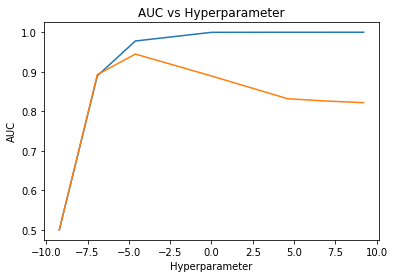

In [212]:
C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
tr_auc = []
cv_auc = []
for c in tqdm(C):
    lr = LogisticRegression(penalty='l1',C=c,class_weight='balanced')
    lr.fit(x_tr_bow,y_tr)
    probtr = lr.predict_proba(x_tr_bow)[:,1]
    tr_auc.append(roc_auc_score(y_tr,probtr))
    probcv = lr.predict_proba(x_cv_bow)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
optimal_c = C[cv_auc.index(max(cv_auc))]
C = [np.log(x) for x in C]
plt.plot(C,tr_auc,label="tr auc")
plt.plot(C,cv_auc,label="cv auc")
plt.title("AUC vs Hyperparameter")
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
print("optimal lambda : ",1//optimal_c)

In [213]:
lr = LogisticRegression(penalty='l1',C=optimal_c,class_weight='balanced')
lr.fit(x_tr_bow,y_tr)
pred = lr.predict(x_te_bow)
# evaluate accuracy
acc = accuracy_score(y_te, pred) * 100
print('\nThe accuracy of the Logistic Regression C = %d is %f%%' % (1//optimal_c, acc))


The accuracy of the Logistic Regression C = 99 is 88.514286%


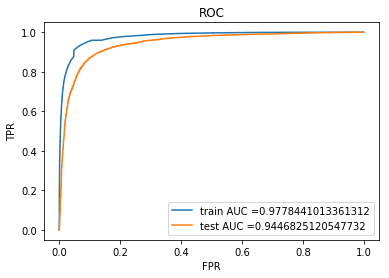

In [214]:
#plotting Auc 
tr_fpr,tr_tpr,threshold = roc_curve(y_tr, lr.predict_proba(x_tr_bow)[:,1])
te_fpr,te_tpr,threshold = roc_curve(y_te, lr.predict_proba(x_te_bow)[:,1])
AUC = str(auc(te_fpr, te_tpr))
plt.plot(tr_fpr,tr_tpr,label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr,te_tpr,label="test AUC ="+str(auc(te_fpr, te_tpr)))
plt.legend()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

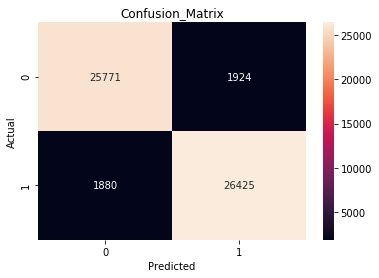

In [215]:
#Confusion Matrix for train
import seaborn as sb
con_matr = confusion_matrix(y_tr, lr.predict(x_tr_bow))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

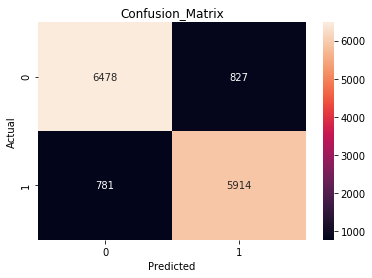

In [216]:
#Confusion Matrix for test
import seaborn as sb
con_matr = confusion_matrix(y_te, lr.predict(x_te_bow))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [217]:
print('='*50)
print(classification_report(y_te, pred))
print('='*50)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      7305
           1       0.88      0.88      0.88      6695

   micro avg       0.89      0.89      0.89     14000
   macro avg       0.88      0.89      0.88     14000
weighted avg       0.89      0.89      0.89     14000



#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [218]:
# Please write all the code with proper documentation
lr = LogisticRegression(penalty='l1',C=optimal_c,class_weight='balanced')
lr.fit(x_tr_bow,y_tr)
weight=lr.coef_
print('No of non zero element in weight vector ',np.count_nonzero(weight))

No of non zero element in weight vector  5684


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:33<00:00, 43.38s/it]


optimal lambda :  9999.0


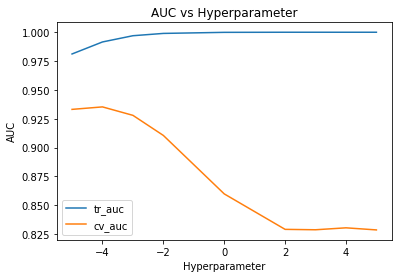

In [219]:
# Please write all the code with proper documentation
C = [10**-5,10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4,10**5]
tr_auc = []
cv_auc = []
for c in tqdm(C):
    lr = LogisticRegression(penalty='l2',C=c,class_weight='balanced')
    lr.fit(x_tr_bow,y_tr)
    probtr = lr.predict_proba(x_tr_bow)[:,1]
    tr_auc.append(roc_auc_score(y_tr,probtr))
    probcv = lr.predict_proba(x_cv_bow)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
optimal_c1 = C[cv_auc.index(max(cv_auc))]
C = [np.log10(x) for x in C]
plt.plot(C,tr_auc,label="tr_auc")
plt.plot(C,cv_auc,label="cv_auc")
plt.legend()
plt.title("AUC vs Hyperparameter")
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
print("optimal lambda : ",1//optimal_c1)

In [220]:
lr = LogisticRegression(penalty='l2',C=optimal_c1,class_weight='balanced')
lr.fit(x_tr_bow,y_tr)
pred1 = lr.predict(x_te_bow)
# evaluate accuracy
acc = accuracy_score(y_te, pred1) * 100
print('\nThe accuracy of the Logistic Regression C = %d is %f%%' % (1//optimal_c1, acc))


The accuracy of the Logistic Regression C = 9999 is 87.771429%


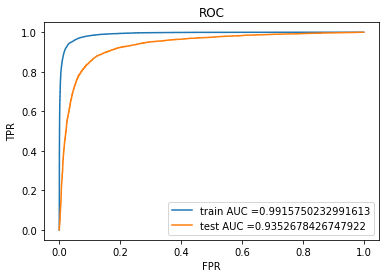

In [221]:
tr_fpr,tr_tpr,threshold = roc_curve(y_tr,lr.predict_proba(x_tr_bow)[:,1])
te_fpr,te_tpr,threshold = roc_curve(y_te,lr.predict_proba(x_te_bow)[:,1])
AUC1=str(auc(te_fpr, te_tpr))
plt.plot(tr_fpr,tr_tpr,label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr,te_tpr,label="test AUC ="+str(auc(te_fpr, te_tpr)))
plt.legend()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

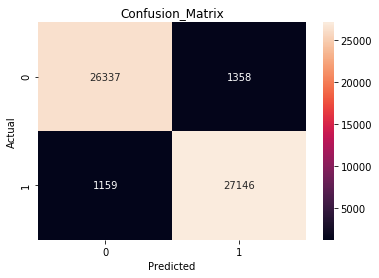

In [222]:
#Confusion Matrix for train
import seaborn as sb
con_matr = confusion_matrix(y_tr, lr.predict(x_tr_bow))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

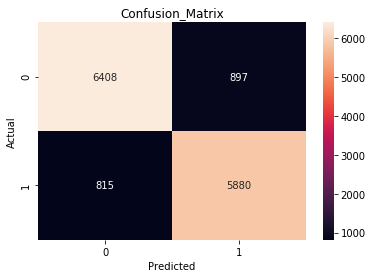

In [223]:
#Confusion Matrix for test
import seaborn as sb
con_matr = confusion_matrix(y_te, lr.predict(x_te_bow))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [224]:
print('='*50)
print(classification_report(y_te, pred1))
print('='*50)

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      7305
           1       0.87      0.88      0.87      6695

   micro avg       0.88      0.88      0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [225]:
# Please write all the code with proper documentation
We_be = lr.coef_
x_e = x_tr_bow
x_e.data = x_e.data+np.random.normal(0,0.001)
print(x_e.shape)

(56000, 46322)


In [226]:
#Training Lr
lr_e = LogisticRegression(penalty='l1',C=optimal_c,class_weight='balanced')
lr_e.fit(x_e,y_tr)
We_af = lr_e.coef_
#To eliminate divisible by zero error we will add 10^-6 to Weight_before and Weight_after
We_be += 10**-6
We_af += 10**-6

p_vec=[]
for i in range(len(We_be[0])):
    val = We_af[0][i]-We_be[0][i]
    val /= We_be[0][i]
    p_vec.append(val)
    
original_per_vec = np.absolute(p_vec)    
p_vec=sorted(np.absolute(p_vec))[::-1]

#percentage change 
p_vec[:10]

[29.364702685432405,
 22.066013042518744,
 22.066013042518744,
 22.066013042518744,
 22.066013042518744,
 22.066013042518744,
 22.066013042518744,
 22.066013042518744,
 22.066013042518744,
 22.066013042518744]

In [227]:
#Percentiles from 0 to 100th
for s in range(0,11):
    print(str(s*10)+"th percentile = "+str(np.percentile(p_vec,s*10)))

0th percentile = 0.00028256006831533977
10th percentile = 0.9364269713213841
20th percentile = 0.9986728722891532
30th percentile = 0.9993818440897684
40th percentile = 0.9996255093844973
50th percentile = 0.999775303293422
60th percentile = 1.000248592578582
70th percentile = 1.0004128292189507
80th percentile = 1.0007182210827603
90th percentile = 1.0018071553663113
100th percentile = 29.364702685432405


In [228]:
#Percentile from 90 to 100
for s in range(90,101):
    print(str(s)+"th percentile = "+str(np.percentile(p_vec,s)))

90th percentile = 1.0018071553663113
91th percentile = 1.0021186455098101
92th percentile = 1.0025720619499299
93th percentile = 1.003254857445071
94th percentile = 1.0043982047783973
95th percentile = 1.006863088851542
96th percentile = 1.0132845970682403
97th percentile = 1.039137547973291
98th percentile = 1.1593004033838152
99th percentile = 1.6053075567334765
100th percentile = 29.364702685432405


In [229]:
#Percentile from 99 to 100
for s in range(1,11):
    print(str(99+(10**-1)*s)+"th percentile ="+str(np.percentile(p_vec,99+(10**-1)*s)))


99.1th percentile =1.7085578837845417
99.2th percentile =1.7930609590248925
99.3th percentile =1.8780741550542643
99.4th percentile =2.019763447602379
99.5th percentile =2.200622347947099
99.6th percentile =2.4083058751633537
99.7th percentile =2.7621027587201916
99.8th percentile =3.176125836958069
99.9th percentile =4.941550606497835
100.0th percentile =29.364702685432405


In [231]:

original_per_vec = original_per_vec.tolist()
a_f = vect.get_feature_names()
# for i in range(1,11):
#     indx=original_per_vec.index(np.percentile(p_vec,99.9+(10**-2)*i))
#     print(a_f[indx])
ind=original_per_vec.index(p_vec[0])
print(a_f[ind])

chipsoctober


## [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [232]:
# Please write all the code with proper documentation
we = lr.coef_
p_index = np.argsort(we)[:,::-1]
for s in list(p_index[0][0:10]):
    print(a_f[s])

great
best
delicious
love
good
perfect
loves
excellent
highly
favorite


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [233]:
# Please write all the code with proper documentation
n_index = np.argsort(we)
for s in list(n_index[0][0:10]):
    print(a_f[s])

not
disappointed
worst
terrible
money
awful
bad
disappointing
horrible
waste


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [234]:
# Please write all the code with proper documentation
vect_tf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
vect_tf.fit(x_tr)
x_tr_tfidf = vect_tf.transform(x_tr)
x_te_tfidf = vect_tf.transform(x_te)
x_cv_tfidf = vect_tf.transform(x_cv)
print(x_tr_tfidf.shape,y_tr.shape)

(56000, 33228) (56000,)


In [235]:
sca = StandardScaler(with_mean=False)
sca.fit(x_tr_tfidf)
x_tr_tfidf = sca.transform(x_tr_tfidf)
x_cv_tfidf = sca.transform(x_cv_tfidf)
x_te_tfidf = sca.transform(x_te_tfidf)
print('='*50)
print(x_tr_tfidf.shape,y_tr.shape)
print(x_cv_tfidf.shape,y_cv.shape)
print(x_te_tfidf.shape,y_te.shape)
print('='*50)

(56000, 33228) (56000,)
(14000, 33228) (14000,)
(14000, 33228) (14000,)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07s/it]


optimal lambda :  99.0


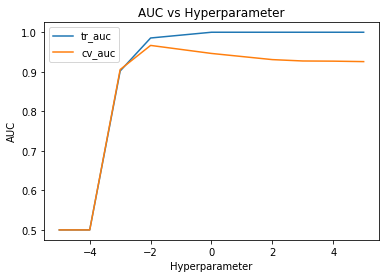

In [236]:
C = [10**-5,10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4,10**5]
tr_auc = []
cv_auc = []
for c in tqdm(C):
    lr = LogisticRegression(penalty='l1',C=c,class_weight='balanced')
    lr.fit(x_tr_tfidf,y_tr)
    probtr = lr.predict_proba(x_tr_tfidf)[:,1]
    tr_auc.append(roc_auc_score(y_tr,probtr))
    probcv = lr.predict_proba(x_cv_tfidf)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
optimal_c2 = C[cv_auc.index(max(cv_auc))]
C = [np.log10(x) for x in C]
plt.plot(C,tr_auc,label="tr_auc")
plt.plot(C,cv_auc,label="cv_auc")
plt.legend()
plt.title("AUC vs Hyperparameter")
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
print("optimal lambda : ",1//optimal_c2)

In [237]:
lr = LogisticRegression(penalty='l1',C=optimal_c2,class_weight='balanced')
lr.fit(x_tr_tfidf,y_tr)
pred2 = lr.predict(x_te_tfidf)
# evaluate accuracy
acc = accuracy_score(y_te, pred2) * 100
print('\nThe accuracy of the Logistic Regression C = %d is %f%%' % (1//optimal_c2, acc))


The accuracy of the Logistic Regression C = 99 is 90.592857%


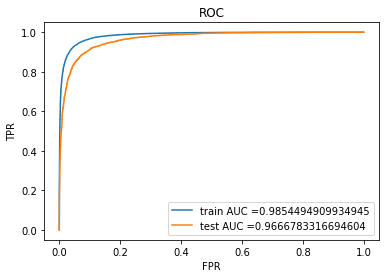

In [238]:
#plotting Auc 
tr_fpr,tr_tpr,threshold = roc_curve(y_tr, lr.predict_proba(x_tr_tfidf)[:,1])
te_fpr,te_tpr,threshold = roc_curve(y_te, lr.predict_proba(x_te_tfidf)[:,1])
AUC2 = str(auc(te_fpr, te_tpr))
plt.plot(tr_fpr,tr_tpr,label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr,te_tpr,label="test AUC ="+str(auc(te_fpr, te_tpr)))
plt.legend()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

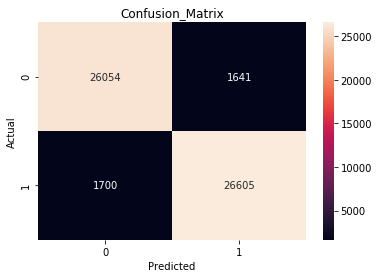

In [239]:
#Confusion Matrix for train
import seaborn as sb
con_matr = confusion_matrix(y_tr, lr.predict(x_tr_tfidf))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

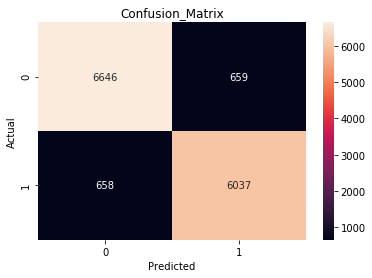

In [240]:
#Confusion Matrix for test
import seaborn as sb
con_matr = confusion_matrix(y_te, lr.predict(x_te_tfidf))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [241]:
print('='*50)
print(classification_report(y_te, pred2))
print('='*50)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      7305
           1       0.90      0.90      0.90      6695

   micro avg       0.91      0.91      0.91     14000
   macro avg       0.91      0.91      0.91     14000
weighted avg       0.91      0.91      0.91     14000



### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:50<00:00,  8.37s/it]


optimal lambda :  9999.0


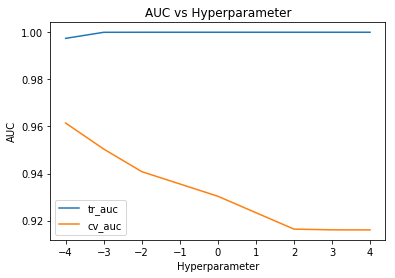

In [242]:
# Please write all the code with proper documentation
C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
tr_auc = []
cv_auc = []
for c in tqdm(C):
    lr = LogisticRegression(penalty='l2',C=c,class_weight='balanced')
    lr.fit(x_tr_tfidf,y_tr)
    probtr = lr.predict_proba(x_tr_tfidf)[:,1]
    tr_auc.append(roc_auc_score(y_tr,probtr))
    probcv = lr.predict_proba(x_cv_tfidf)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
optimal_c3 = C[cv_auc.index(max(cv_auc))]
C = [np.log10(x) for x in C]
plt.plot(C,tr_auc,label="tr_auc")
plt.plot(C,cv_auc,label="cv_auc")
plt.legend()
plt.title("AUC vs Hyperparameter")
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
print("optimal lambda : ",1//optimal_c3)

In [243]:
lr = LogisticRegression(penalty='l2',C=optimal_c3,class_weight='balanced')
lr.fit(x_tr_tfidf,y_tr)
pred3 = lr.predict(x_te_tfidf)
# evaluate accuracy
acc = accuracy_score(y_te, pred3) * 100
print('\nThe accuracy of the Logistic Regression C = %d is %f%%' % (1//optimal_c3, acc))


The accuracy of the Logistic Regression C = 9999 is 89.364286%


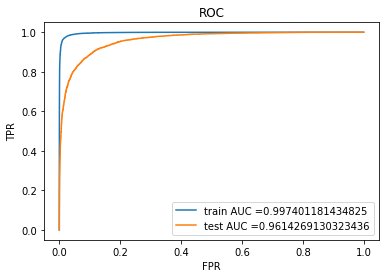

In [244]:
#plotting Auc 
tr_fpr,tr_tpr,threshold = roc_curve(y_tr, lr.predict_proba(x_tr_tfidf)[:,1])
te_fpr,te_tpr,threshold = roc_curve(y_te, lr.predict_proba(x_te_tfidf)[:,1])
AUC3 = str(auc(te_fpr, te_tpr))
plt.plot(tr_fpr,tr_tpr,label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr,te_tpr,label="test AUC ="+str(auc(te_fpr, te_tpr)))
plt.legend()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

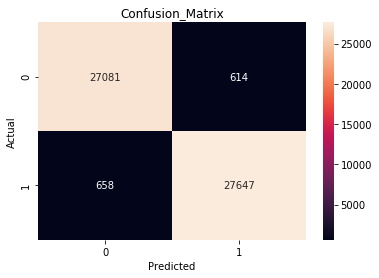

In [245]:
#Confusion Matrix for train
import seaborn as sb
con_matr = confusion_matrix(y_tr, lr.predict(x_tr_tfidf))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

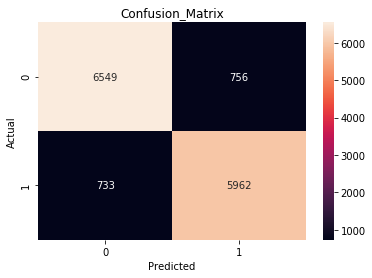

In [246]:
#Confusion Matrix for test
import seaborn as sb
con_matr = confusion_matrix(y_te, lr.predict(x_te_tfidf))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [247]:
print('='*50)
print(classification_report(y_te,pred3))
print('='*50)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      7305
           1       0.89      0.89      0.89      6695

   micro avg       0.89      0.89      0.89     14000
   macro avg       0.89      0.89      0.89     14000
weighted avg       0.89      0.89      0.89     14000



### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [248]:
# Please write all the code with proper documentation
we = lr.coef_
p_index = np.argsort(we)[:,::-1]
for s in list(p_index[0][0:10]):
    print(a_f[s])

earns
chihauhua
aspertame
gamja
dorothy
jolted
cornstarch
gene
radishy
crisis


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [249]:
# Please write all the code with proper documentation
n_index = np.argsort(we)
for s in list(n_index[0][0:10]):
    print(a_f[s])

homeowner
cited
huhm
hoped
rang
icebreakers
imparting
claim
parasites
reaffirmed


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [250]:
# Please write all the code with proper documentation
i=0
list_of_sentance_tr=[]
for sentance in x_tr:
    list_of_sentance_tr.append(sentance.split())
    
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_tr,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14919
sample words  ['remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'along', 'children', 'tradition', 'lives', 'one', 'movie', 'collection', 'filled', 'comedy', 'action', 'whatever', 'else', 'want', 'call', 'getting', 'crazy', 'really', 'impossible', 'today', 'not', 'find', 'french', 'version', 'film', 'could', 'u', 'please']


In [251]:
##Train
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_tr): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
#print(sent_vectors_tr[0])

##CV
i=0 
list_of_sentance_cv = []
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv=[];# the avg-w2v for each sentence/review in CV is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
#print(sent_vectors_cv[0])

##Test
i=0 
list_of_sentance_te = []
for sentance in x_te:
    list_of_sentance_te.append(sentance.split())
sent_vectors_te = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_te): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_te.append(sent_vec)
print(len(sent_vectors_te))
#print(sent_vectors_te[0])

100%|███████████████████████████████████████████████████████████████████████████| 56000/56000 [02:11<00:00, 425.27it/s]


56000


100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:34<00:00, 403.09it/s]


14000


100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:34<00:00, 402.54it/s]


14000


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.65s/it]


optimal lambda :  0


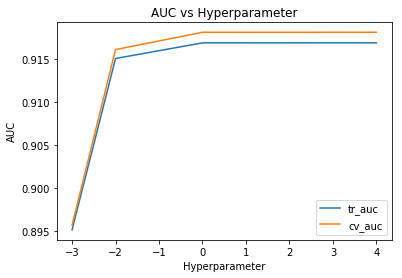

In [252]:
# Please write all the code with proper documentation
x_tr_w2v = sent_vectors_tr
x_cv_w2v = sent_vectors_cv
x_te_w2v = sent_vectors_te

C = [10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
tr_auc = []
cv_auc = []
for c in tqdm(C):
    lr = LogisticRegression(penalty='l1',C=c,class_weight='balanced')
    lr.fit(x_tr_w2v,y_tr)
    probtr = lr.predict_proba(x_tr_w2v)[:,1]
    tr_auc.append(roc_auc_score(y_tr,probtr))
    probcv = lr.predict_proba(x_cv_w2v)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
optimal_c4 = C[cv_auc.index(max(cv_auc))]
C = [np.log10(x) for x in C]
plt.plot(C,tr_auc,label="tr_auc")
plt.plot(C,cv_auc,label="cv_auc")
plt.legend()
plt.title("AUC vs Hyperparameter")
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
print("optimal lambda : ",1//optimal_c4)

In [253]:
lr = LogisticRegression(penalty='l1',C=optimal_c4,class_weight='balanced')
lr.fit(x_tr_w2v,y_tr)
pred4 = lr.predict(x_te_w2v)
# evaluate accuracy
acc = accuracy_score(y_te, pred4) * 100
print('\nThe accuracy of the Logistic Regression C = %d is %f%%' % (optimal_c4, acc))


The accuracy of the Logistic Regression C = 1000 is 83.950000%


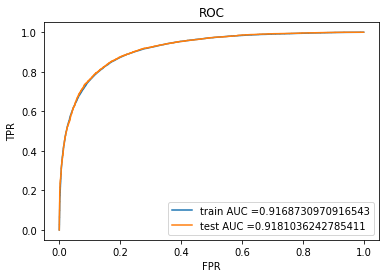

In [254]:
#plotting Auc 
tr_fpr,tr_tpr,threshold = roc_curve(y_tr, lr.predict_proba(x_tr_w2v)[:,1])
te_fpr,te_tpr,threshold =  roc_curve(y_te, lr.predict_proba(x_te_w2v)[:,1])
AUC4 = str(auc(te_fpr, te_tpr))
plt.plot(tr_fpr,tr_tpr,label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr,te_tpr,label="test AUC ="+str(auc(te_fpr, te_tpr)))
plt.legend()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

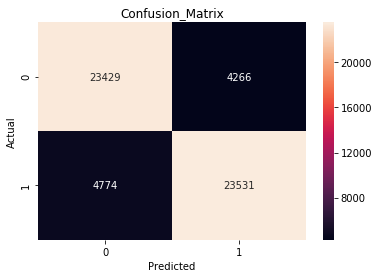

In [255]:
#Confusion Matrix for train
import seaborn as sb
con_matr = confusion_matrix(y_tr, lr.predict(x_tr_w2v))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

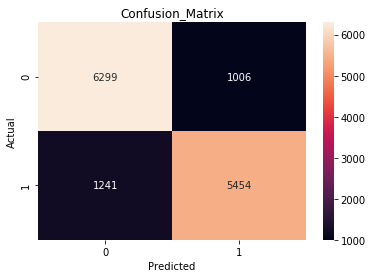

In [256]:
#Confusion Matrix for test
import seaborn as sb
con_matr = confusion_matrix(y_te, lr.predict(x_te_w2v))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [257]:
print('='*50)
print(classification_report(y_te, pred4))
print('='*50)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      7305
           1       0.84      0.81      0.83      6695

   micro avg       0.84      0.84      0.84     14000
   macro avg       0.84      0.84      0.84     14000
weighted avg       0.84      0.84      0.84     14000



### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.23s/it]


optimal lambda :  0


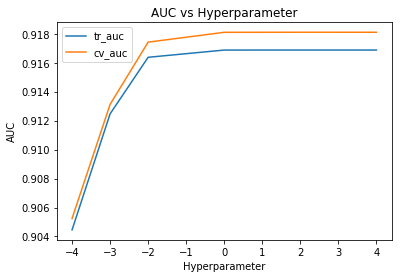

In [258]:
# Please write all the code with proper documentation
C = [10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4]
tr_auc = []
cv_auc = []
for c in tqdm(C):
    lr = LogisticRegression(penalty='l2',C=c,class_weight='balanced')
    lr.fit(x_tr_w2v,y_tr)
    probtr = lr.predict_proba(x_tr_w2v)[:,1]
    tr_auc.append(roc_auc_score(y_tr,probtr))
    probcv = lr.predict_proba(x_cv_w2v)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
optimal_c5 = C[cv_auc.index(max(cv_auc))]
C = [np.log10(x) for x in C]
plt.plot(C,tr_auc,label="tr_auc")
plt.plot(C,cv_auc,label="cv_auc")
plt.legend()
plt.title("AUC vs Hyperparameter")
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
print("optimal lambda : ",1//optimal_c5)

In [259]:
lr = LogisticRegression(penalty='l2',C=optimal_c5,class_weight='balanced')
lr.fit(x_tr_w2v,y_tr)
pred5 = lr.predict(x_te_w2v)
# evaluate accuracy
acc = accuracy_score(y_te, pred5) * 100
print('\nThe accuracy of the Logistic Regression C = %d is %f%%' % (optimal_c5, acc))


The accuracy of the Logistic Regression C = 100 is 83.942857%


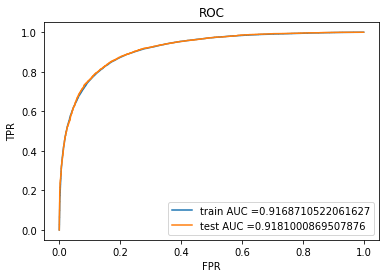

In [260]:
#plotting Auc 
tr_fpr,tr_tpr,threshold = roc_curve(y_tr, lr.predict_proba(x_tr_w2v)[:,1])
te_fpr,te_tpr,threshold =  roc_curve(y_te, lr.predict_proba(x_te_w2v)[:,1])
AUC5 = str(auc(te_fpr, te_tpr))
plt.plot(tr_fpr,tr_tpr,label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr,te_tpr,label="test AUC ="+str(auc(te_fpr, te_tpr)))
plt.legend()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

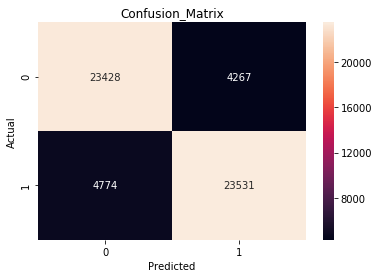

In [261]:
#Confusion Matrix for train
import seaborn as sb
con_matr = confusion_matrix(y_tr, lr.predict(x_tr_w2v))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

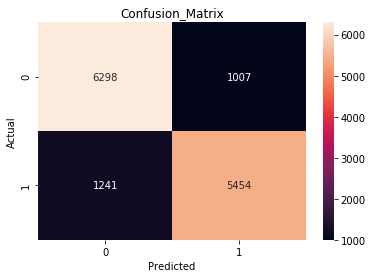

In [262]:
#Confusion Matrix for test
import seaborn as sb
con_matr = confusion_matrix(y_te, lr.predict(x_te_w2v))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [263]:
print('='*50)
print(classification_report(y_te, pred5))
print('='*50)

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      7305
           1       0.84      0.81      0.83      6695

   micro avg       0.84      0.84      0.84     14000
   macro avg       0.84      0.84      0.84     14000
weighted avg       0.84      0.84      0.84     14000



## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [264]:
# Please write all the code with proper documentation
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [265]:
##train
i=0
list_of_sentance_tr=[]
for sentance in x_tr:
    list_of_sentance_tr.append(sentance.split())
    
# TF-IDF weighted Word2Vec
tfidf_feat = vect_tf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_tr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1
    
##cv
i=0
list_of_sentance_cv=[]
for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())
    
# TF-IDF weighted Word2Vec
tfidf_feat = vect_tf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
    
##test
i=0
list_of_sentance_te=[]
for sentance in x_te:
    list_of_sentance_te.append(sentance.split())
    
# TF-IDF weighted Word2Vec
tfidf_feat = vect_tf.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_te = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_te): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_te.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 14000/14000 [06:14<00:00, 37.36it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.76s/it]


optimal lambda :  0


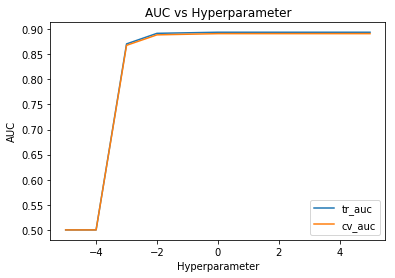

In [266]:
x_tr_tfw2v = tfidf_sent_vectors_tr
x_cv_tfw2v = tfidf_sent_vectors_cv
x_te_tfw2v = tfidf_sent_vectors_te

C = [10**-5,10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4,10**5]
tr_auc = []
cv_auc = []
for c in tqdm(C):
    lr = LogisticRegression(penalty='l1',C=c,class_weight='balanced')
    lr.fit(x_tr_tfw2v,y_tr)
    probtr = lr.predict_proba(x_tr_tfw2v)[:,1]
    tr_auc.append(roc_auc_score(y_tr,probtr))
    probcv = lr.predict_proba(x_cv_tfw2v)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
optimal_c6 = C[cv_auc.index(max(cv_auc))]
C = [np.log10(x) for x in C]
plt.plot(C,tr_auc,label="tr_auc")
plt.plot(C,cv_auc,label="cv_auc")
plt.legend()
plt.title("AUC vs Hyperparameter")
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
print("optimal lambda : ",1//optimal_c6)

In [267]:
lr = LogisticRegression(penalty='l1',C=optimal_c6,class_weight='balanced')
lr.fit(x_tr_tfw2v,y_tr)
pred6 = lr.predict(x_te_tfw2v)
# evaluate accuracy
acc = accuracy_score(y_te, pred6) * 100
print('\nThe accuracy of the Logistic Regression C = %d is %f%%' % (optimal_c6, acc))


The accuracy of the Logistic Regression C = 1000 is 80.985714%


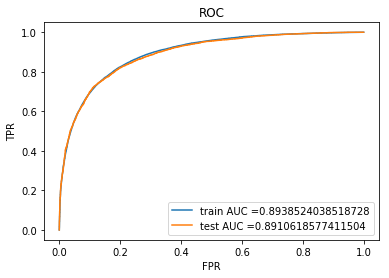

In [268]:
#plotting Auc 
tr_fpr,tr_tpr,threshold = roc_curve(y_tr, lr.predict_proba(x_tr_tfw2v)[:,1])
te_fpr,te_tpr,threshold =  roc_curve(y_te, lr.predict_proba(x_te_tfw2v)[:,1])
AUC6 = str(auc(te_fpr, te_tpr))
plt.plot(tr_fpr,tr_tpr,label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr,te_tpr,label="test AUC ="+str(auc(te_fpr, te_tpr)))
plt.legend()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

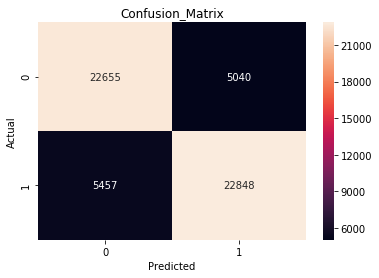

In [269]:
#Confusion Matrix for train
import seaborn as sb
con_matr = confusion_matrix(y_tr, lr.predict(x_tr_tfw2v))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

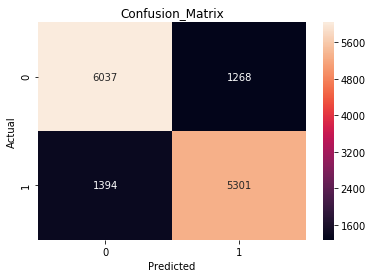

In [270]:
#Confusion Matrix for test
import seaborn as sb
con_matr = confusion_matrix(y_te, lr.predict(x_te_tfw2v))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [271]:
print('='*50)
print(classification_report(y_te, pred6))
print('='*50)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      7305
           1       0.81      0.79      0.80      6695

   micro avg       0.81      0.81      0.81     14000
   macro avg       0.81      0.81      0.81     14000
weighted avg       0.81      0.81      0.81     14000



### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.38s/it]


optimal lambda :  0


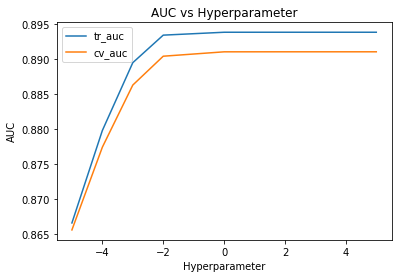

In [272]:
C = [10**-5,10**-4,10**-3, 10**-2, 10**0, 10**2,10**3,10**4,10**5]
tr_auc = []
cv_auc = []
for c in tqdm(C):
    lr = LogisticRegression(penalty='l2',C=c,class_weight='balanced')
    lr.fit(x_tr_tfw2v,y_tr)
    probtr = lr.predict_proba(x_tr_tfw2v)[:,1]
    tr_auc.append(roc_auc_score(y_tr,probtr))
    probcv = lr.predict_proba(x_cv_tfw2v)[:,1]
    cv_auc.append(roc_auc_score(y_cv,probcv))
optimal_c7 = C[cv_auc.index(max(cv_auc))]
C = [np.log10(x) for x in C]
plt.plot(C,tr_auc,label="tr_auc")
plt.plot(C,cv_auc,label="cv_auc")
plt.legend()
plt.title("AUC vs Hyperparameter")
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
print("optimal lambda : ",1//optimal_c7)

In [273]:
lr = LogisticRegression(penalty='l2',C=optimal_c7,class_weight='balanced')
lr.fit(x_tr_tfw2v,y_tr)
pred7 = lr.predict(x_te_tfw2v)
# evaluate accuracy
acc = accuracy_score(y_te, pred7) * 100
print('\nThe accuracy of the Logistic Regression C = %d is %f%%' % (1//optimal_c7, acc))


The accuracy of the Logistic Regression C = 0 is 80.992857%


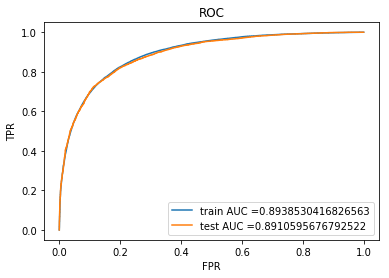

In [274]:
#plotting Auc 
tr_fpr,tr_tpr,threshold = roc_curve(y_tr, lr.predict_proba(x_tr_tfw2v)[:,1])
te_fpr,te_tpr,threshold =  roc_curve(y_te, lr.predict_proba(x_te_tfw2v)[:,1])
AUC7 = str(auc(te_fpr, te_tpr))
plt.plot(tr_fpr,tr_tpr,label="train AUC ="+str(auc(tr_fpr, tr_tpr)))
plt.plot(te_fpr,te_tpr,label="test AUC ="+str(auc(te_fpr, te_tpr)))
plt.legend()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

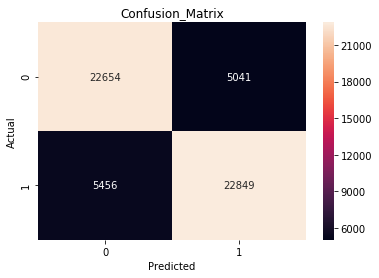

In [275]:
#Confusion Matrix for train
import seaborn as sb
con_matr = confusion_matrix(y_tr, lr.predict(x_tr_tfw2v))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

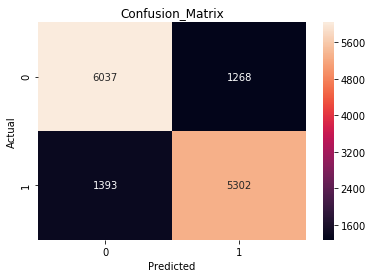

In [276]:
#Confusion Matrix for train
import seaborn as sb
con_matr = confusion_matrix(y_te, lr.predict(x_te_tfw2v))
c_l = [0, 1] #Class Label
df_con_matr = pd.DataFrame(con_matr, index=c_l, columns=c_l)
sb.heatmap(df_con_matr, annot=True, fmt='d')
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [277]:
print('='*50)
print(classification_report(y_te, pred7))
print('='*50)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      7305
           1       0.81      0.79      0.80      6695

   micro avg       0.81      0.81      0.81     14000
   macro avg       0.81      0.81      0.81     14000
weighted avg       0.81      0.81      0.81     14000



# [6] Conclusions

In [284]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
comparison = PrettyTable()
comparison.field_names = ["Vectorizer", "Regularization", "Hyperparameter", "AUC"]
comparison.add_row(["BOW", 'L1', optimal_c, np.round(float(AUC),3)])
comparison.add_row(["TFIDF", 'L1', optimal_c2, np.round(float(AUC2),3)])
comparison.add_row(["AVG W2V", 'L1', 1/optimal_c4, np.round(float(AUC4),3)])
comparison.add_row(["Weighted W2V", 'L1', 1/optimal_c6,np.round(float(AUC6),3)])
comparison.add_row(["BOW", 'L2', optimal_c1, np.round(float(AUC1),3)])
comparison.add_row(["TFIDF", 'L2', optimal_c3, np.round(float(AUC3),3)])
comparison.add_row(["AVG W2V", 'L2', 1/optimal_c5, np.round(float(AUC5),3)])
comparison.add_row(["Weighted W2V", 'L2', 1/optimal_c7, np.round(float(AUC7),3)])
print(comparison)

+--------------+----------------+----------------+-------+
|  Vectorizer  | Regularization | Hyperparameter |  AUC  |
+--------------+----------------+----------------+-------+
|     BOW      |       L1       |      0.01      | 0.945 |
|    TFIDF     |       L1       |      0.01      | 0.967 |
|   AVG W2V    |       L1       |     0.001      | 0.918 |
| Weighted W2V |       L1       |     0.001      | 0.891 |
|     BOW      |       L2       |     0.0001     | 0.935 |
|    TFIDF     |       L2       |     0.0001     | 0.961 |
|   AVG W2V    |       L2       |      0.01      | 0.918 |
| Weighted W2V |       L2       |     0.0001     | 0.891 |
+--------------+----------------+----------------+-------+
